In [33]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tiff
from patchify import patchify

import unet
from utils import unpickle

%load_ext autoreload
%autoreload 2
# %load_ext tensorboard
# %tensorboard --logdir logs

# plt.style.use("lusk")


def add_ndvi_to_raster(rgbi):
    # Add NDVI
    # Allow division by zero
    np.seterr(divide="ignore", invalid="ignore")
    r = rgbi.astype(np.float64)
    ndvi = (r[..., -1] - r[..., 0]) / (r[..., -1] + r[..., 0])
    r = r.astype(np.uint8)
    ndvi[np.isnan(ndvi)] = -1
    # Normalize and convert to 255 range
    ndvi = (((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())) * 255).astype(np.uint8)
    r = np.dstack((r, ndvi))
    return r

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the stats

In [3]:
cl_1 = np.load("stats/5folds_CV_classes_1.npy", allow_pickle=True)
cl_1_5 = np.load("stats/5folds_CV_classes_1-5.npy", allow_pickle=True)
cl_1_2_5 = np.load("stats/5folds_CV_classes_1-2-5.npy", allow_pickle=True)

In [4]:
df = pd.DataFrame(
    np.c_[np.repeat("Class 1", len(cl_1[:, -3:])), cl_1[:, -3:]],
    columns=["IoU Type", "Overall bIoU", "Class bIoU", "BG bIoU"],
)
df = df.append(
    pd.DataFrame(
        np.c_[np.repeat("Class 1_5", len(cl_1_5[:, -3:])), cl_1_5[:, -3:]],
        columns=df.columns,
    ),
    ignore_index=True,
)
df = df.append(
    pd.DataFrame(
        np.c_[np.repeat("Class_1_2_5", len(cl_1_2_5[:, -3:])), cl_1_2_5[:, -3:]],
        columns=df.columns,
    ),
    ignore_index=True,
)

for i in range(1, 4):
    df.iloc[:, i] = df.iloc[:, i].astype(np.float32)

pd.options.display.float_format = "{:.3f}".format

/tmp/ipykernel_230082/1652372418.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(np.c_[np.repeat("Class 1_5", len(cl_1_5[:, -3:])), cl_1_5[:, -3:]], columns=df.columns), ignore_index=True)
/tmp/ipykernel_230082/1652372418.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(np.c_[np.repeat("Class_1_2_5", len(cl_1_2_5[:, -3:])), cl_1_2_5[:, -3:]], columns=df.columns), ignore_index=True)


In [13]:
cl_1_5[:, -3]

array([0.6557978, 0.66870224, 0.65316385, 0.6360875, 0.63084],
      dtype=object)

In [14]:
df

,IoU Type,Overall bIoU,Class bIoU,BG bIoU
0,Class 1,0.707,0.440,0.974
1,Class 1,0.673,0.376,0.971
2,Class 1,0.648,0.326,0.969
3,Class 1,0.609,0.251,0.967
4,Class 1,0.690,0.410,0.970
5,Class 1_5,0.656,0.421,0.890
6,Class 1_5,0.669,0.443,0.894
7,Class 1_5,0.653,0.418,0.888
8,Class 1_5,0.636,0.391,0.881
9,Class 1_5,0.631,0.382,0.880


In [22]:
cl_1[..., -3:].astype(np.float64).mean(axis=0)

array([0.66548144, 0.36055446, 0.9704084 ])

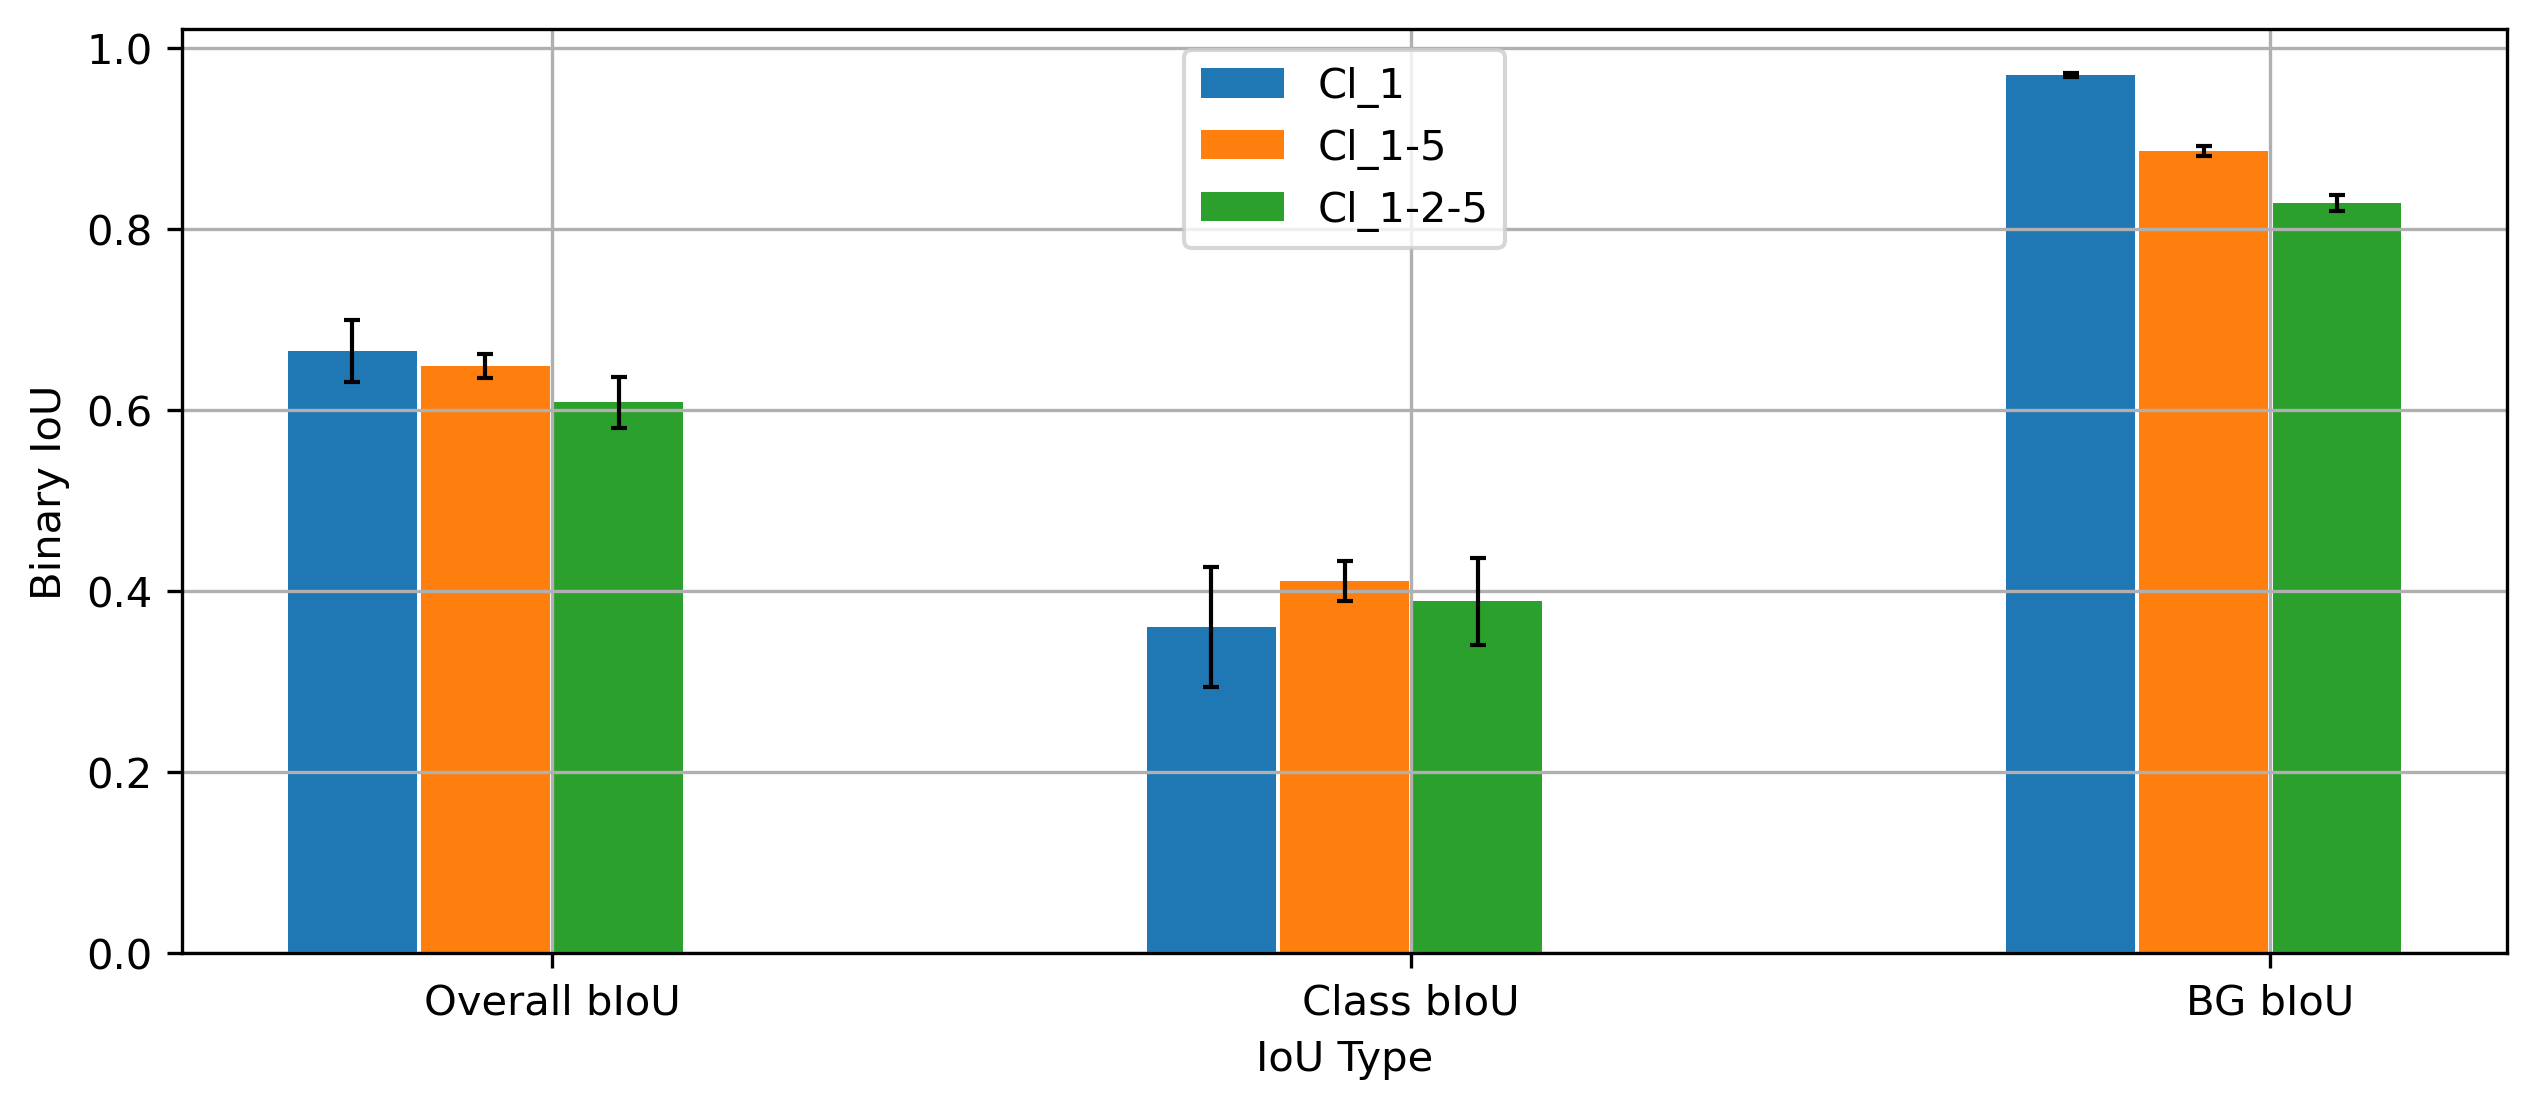

In [24]:
def get_ious(arr):
    return arr[..., -3:].astype(np.float64)


cl_1_iou = get_ious(cl_1)
cl_1_5_iou = get_ious(cl_1_5)
cl_1_2_5_iou = get_ious(cl_1_2_5)

titles = ["Overall bIoU", "Class bIoU", "BG bIoU"]

_, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
width = 0.15
spacing = 0.155
r = np.arange(3)

errs = {"elinewidth": 1, "capsize": 2}

ax.bar(
    r - 1.5 * spacing,
    cl_1_iou.mean(axis=0),
    width,
    label="Cl_1",
    yerr=cl_1_iou.std(axis=0),
    error_kw=errs,
)
ax.bar(
    r - 0.5 * spacing,
    cl_1_5_iou.mean(axis=0),
    width,
    label="Cl_1-5",
    yerr=cl_1_5_iou.std(axis=0),
    error_kw=errs,
)
ax.bar(
    r + 0.5 * spacing,
    cl_1_2_5_iou.mean(axis=0),
    width,
    label="Cl_1-2-5",
    yerr=cl_1_2_5_iou.astype(float).std(axis=0),
    error_kw=errs,
)

ax.set_xticks(r, titles)
ax.set_xlabel("IoU Type")
ax.set_ylabel("Binary IoU")
ax.grid()
ax.legend(fontsize=10, loc="upper center")
# ax.set_ylim(0.2, 0.95)

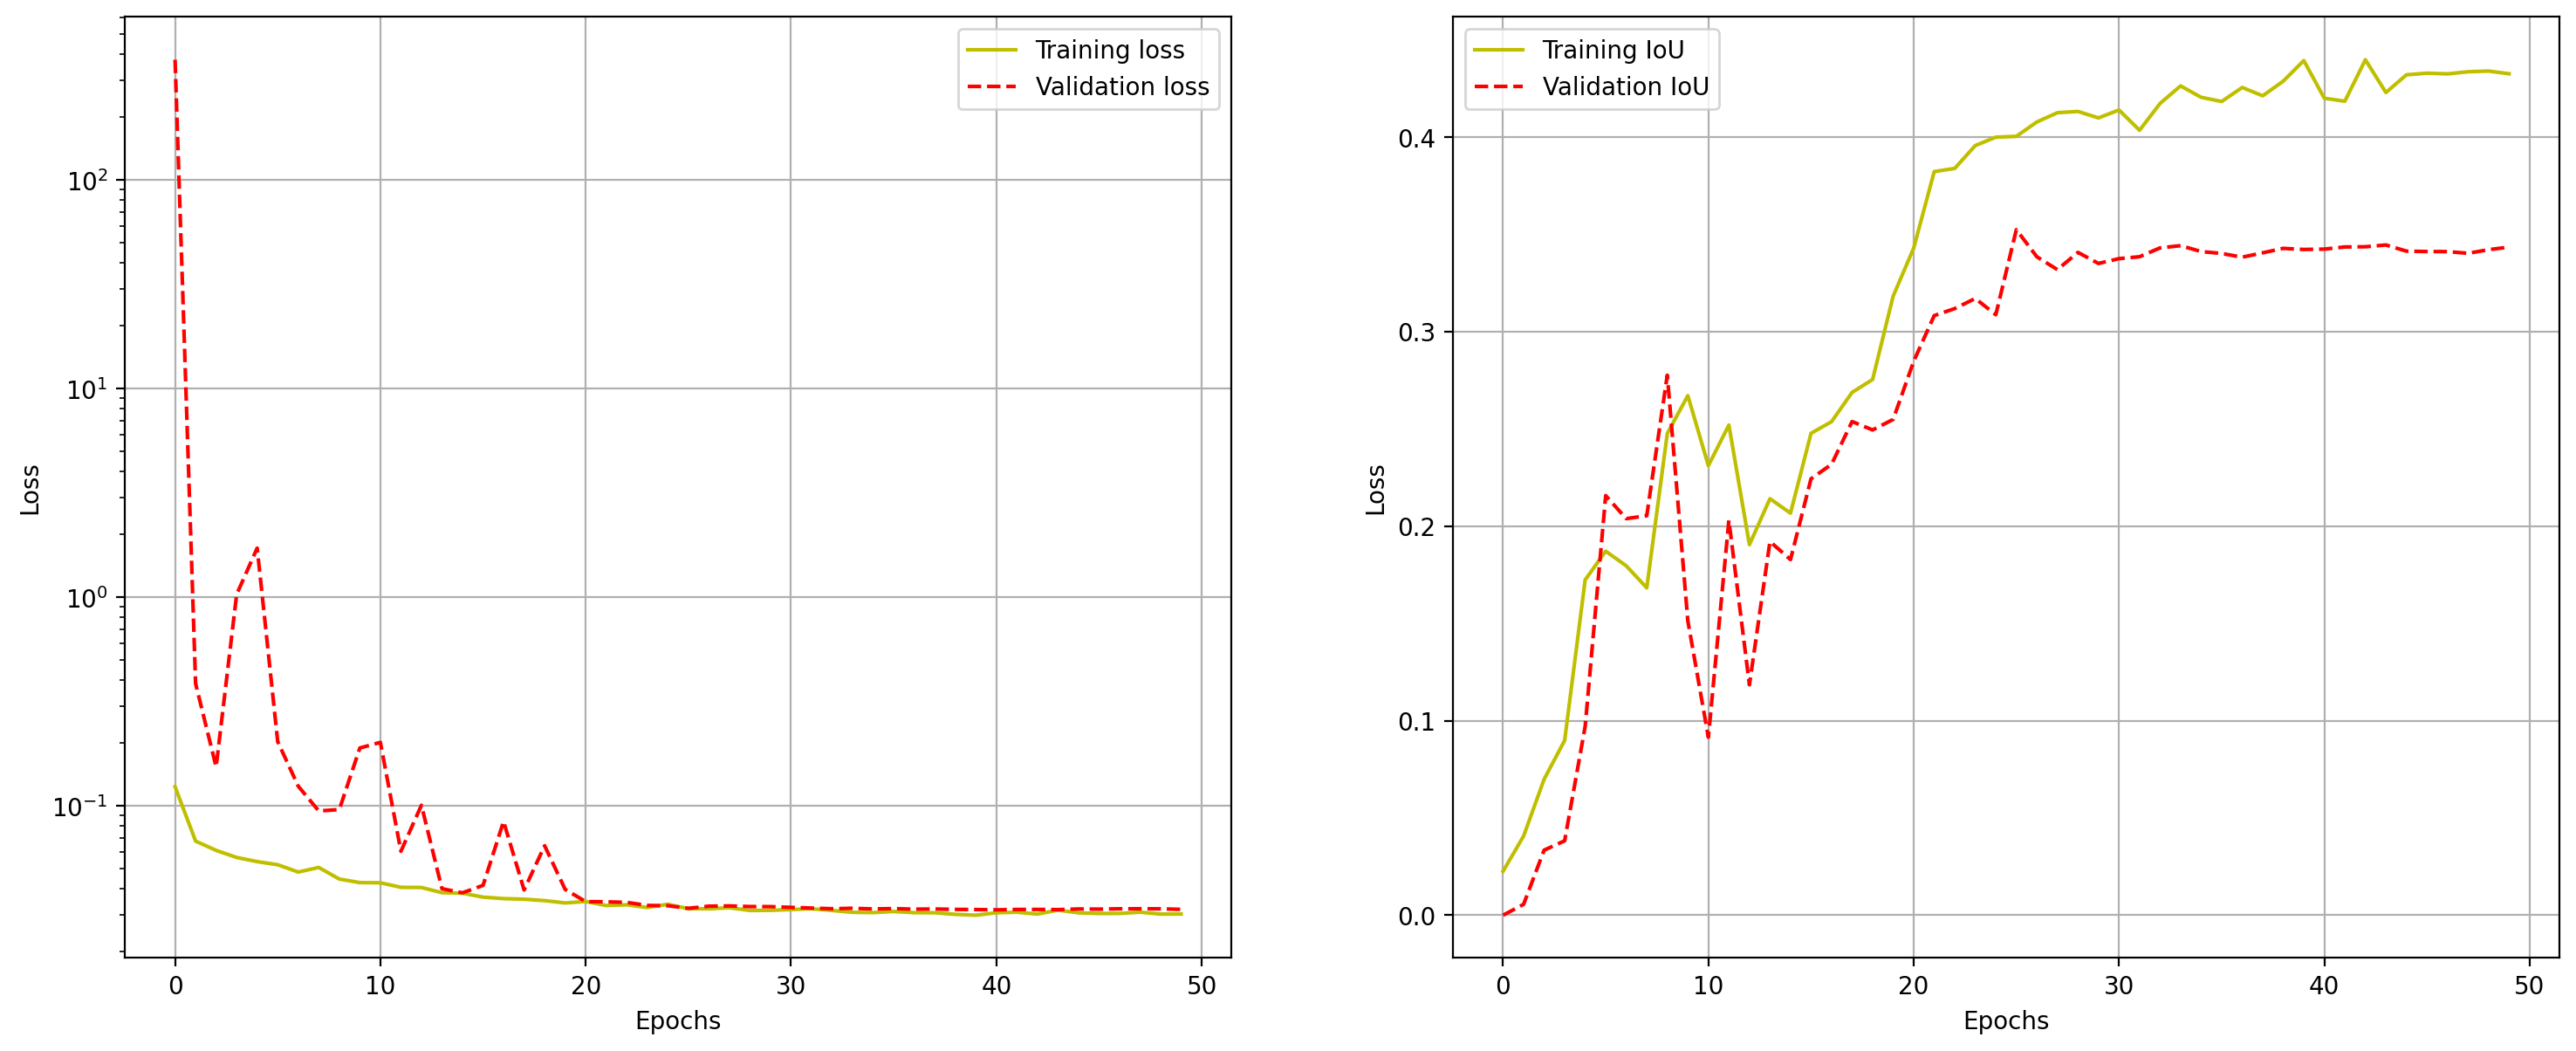

In [26]:
loss = unpickle(cl_1[:, 0])
val_loss = unpickle(cl_1[:, 1])
iou = unpickle(cl_1[:, 2])
val_iou = unpickle(cl_1[:, 3])
epochs = np.arange(0, loss.shape[-1], 1)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 7), dpi=200)

ax0.semilogy(epochs, loss.mean(axis=0), "y", label="Training loss")
ax0.semilogy(epochs, val_loss.mean(axis=0), "r--", label="Validation loss")
ax0.set_xlabel("Epochs")
ax0.set_ylabel("Loss")
ax0.legend()
ax0.grid()

ax1.plot(epochs, iou.mean(axis=0), "y", label="Training IoU")
ax1.plot(epochs, val_iou.mean(axis=0), "r--", label="Validation IoU")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid()

## Predictions

Load the data

In [34]:
data_dir = "data/WA_Kivalina_01_20219703/20cm/Ortho"
include_nir = True
add_ndvi = True


def get_patched_data(
    rgb_fns,
    img_size,
    channels=False,
    merge_channel=False,
    add_ndvi=False,
    squash=True,
    img_size_override=None,
):

    assert len(rgb_fns) > 0, "Raster list is empty."
    samp_rast = tiff.imread(rgb_fns[0])
    img_base_size = img_size_override if img_size_override else samp_rast.shape[0]
    n = len(rgb_fns)
    m = (img_base_size // img_size) ** 2
    bad_ims = []

    if not channels:
        channels = samp_rast.shape[-1]

    data = np.zeros((n * m, img_size, img_size, channels))

    for k in range(n):
        # Read in RGB and labels
        rgb = tiff.imread(rgb_fns[k])

        if merge_channel:
            # Add NIR
            nir = tiff.imread(merge_channel[k])
            r = np.dstack((rgb, nir))

            if add_ndvi:
                r = add_ndvi_to_raster(r)
        else:
            # Just use RGB
            r = rgb

        # Only include patches that are square and match the img_size_override
        # dimension (if set), and that contain no 0 (nodata) values.
        if (
            img_size_override
            and (r.shape[0] == img_size_override and r.shape[1] == img_size_override)
        ) or not img_size_override:
            # Only read in the specified number of channels from input raster
            patches = patchify(
                r,
                (img_size, img_size, channels),
                step=img_size,
            )
            data[k * m : (k + 1) * m, :, :, :] = patches.reshape(
                -1, img_size, img_size, channels
            )

        else:
            bad_ims.append(rgb_fns[k])

    if img_size_override and len(bad_ims) > 0:
        print("\nRemoving irregular-shaped images...")
        print("-------------------------------------")
        print("bad ims length:", len(bad_ims))
        print("m:", m)
        print("Cull rows:", -len(bad_ims) * m)
        print("Shape before:", data.shape)
        bad_im_idx = np.arange(-len(bad_ims) * m, 0, 1)
        data = np.delete(data, bad_im_idx, axis=0)
        print("Shape after:", data.shape)

    data = data.astype(np.float16) / 255

    return data


rgb_fns = []
nir_fns = [] if include_nir else None

dirs = glob.glob(f"{data_dir}/*")

for dir in dirs:
    rgb = glob.glob(f"{dir}/rgb/*.tif")[0]
    nir = glob.glob(f"{dir}/nir/*.tif")[0] if include_nir else None
    rgb_fns.append(rgb)
    if include_nir:
        nir_fns.append(nir)

if include_nir and add_ndvi:
    data = get_patched_data(
        rgb_fns,
        512,
        channels=5,
        merge_channel=nir_fns,
        add_ndvi=True,
        squash=True,
        img_size_override=2500,
    )


Removing irregular-shaped images...
-------------------------------------
bad ims length: 2
m: 16
Cull rows: -32
Shape before: (368, 512, 512, 5)
Shape after: (336, 512, 512, 5)


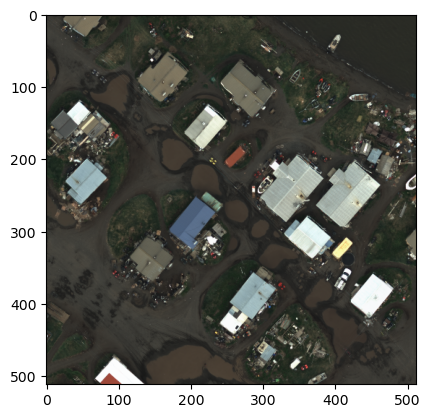

In [59]:
k = np.random.randint(0, data.shape[0])
plt.imshow(data[k][..., :3].astype(np.float32))

In [ ]:
WEIGHTS = "logs/20230119-190358_KF3of5_classes_1-5/KF3of5_classes_1-5_best_wg.h5"

input_shape = data.shape[1:]
model = unet.build_unet(input_shape)
model.load_weights(WEIGHTS)
y_pred = model.predict(data[193])

2023-01-22 09:57:47.978671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 09:57:47.981897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 09:57:47.982018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 09:57:47.982240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags